# Trader Performance Classification: A Machine Learning Approach

## Overview
This project aims to classify traders into **high** or **low performers** using their Trading Quality Score (TQS) and other performance metrics. We build a classification pipeline using:
- **Random Forest**
- **XGBoost**

We further evaluate models with classification metrics, confusion matrices, feature importance, and SHAP for interpretability.

---

## Objectives
1. Load and preprocess the trader performance dataset.
2. Define binary labels based on top 25% TQS.
3. Train Random Forest and XGBoost classifiers.
4. Evaluate model performance with metrics and visualizations.
5. Interpret models with feature importance and SHAP.

---



In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
import xgboost as xgb

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from xgboost import plot_importance
import joblib

import warnings
warnings.filterwarnings("ignore")


## 1️. Load and Explore the Data
We start by loading the dataset and inspecting basic statistics and missing values.


In [8]:
df = pd.read_csv('../data/processed/trader_classification_dataset.csv')

df.head()

,user_id,num_trades,total_profit_x,win_rate,avg_profit_rate,std_profit_rate,total_commission,total_lot_size,avg_lot_size,avg_duration_hr,profit_factor,max_win_streak,max_loss_streak,risk_reward_ratio,total_profit_y,inv_max_loss_streak,TQS
0,127,10,167.21,0.700000,1.000000,0.000000,0.00,1.00,0.100000,0.118028,1.622756,5,2,0.695467,167.21,-2,0.282912
1,208,10,-294.04,0.400000,1.000000,0.000000,-15.30,7.75,0.775000,1.050139,0.312830,2,2,0.391038,-294.04,-2,0.279334
2,238,11,-283.70,0.181818,0.909726,0.299407,-11.40,5.70,0.518182,0.381490,0.065239,1,7,0.293575,-283.70,-7,0.273751
3,299,10,156.50,0.700000,0.900697,0.314025,-2.64,2.57,0.257000,18.775750,2.907839,4,3,1.246217,156.50,-3,0.281185
4,313,10,-650.64,0.200000,1.000000,0.000000,-18.92,9.46,0.946000,1.622861,0.017368,1,4,0.069472,-650.64,-4,0.275654


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17079 entries, 0 to 17078
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              17079 non-null  int64  
 1   num_trades           17079 non-null  int64  
 2   total_profit_x       17079 non-null  float64
 3   win_rate             17079 non-null  float64
 4   avg_profit_rate      17079 non-null  float64
 5   std_profit_rate      17079 non-null  float64
 6   total_commission     17079 non-null  float64
 7   total_lot_size       17079 non-null  float64
 8   avg_lot_size         17079 non-null  float64
 9   avg_duration_hr      17079 non-null  float64
 10  profit_factor        16974 non-null  float64
 11  max_win_streak       17079 non-null  int64  
 12  max_loss_streak      17079 non-null  int64  
 13  risk_reward_ratio    16974 non-null  float64
 14  total_profit_y       17079 non-null  float64
 15  inv_max_loss_streak  17079 non-null 

In [10]:
print("\nMissing Values:")
display(df.isnull().sum())


Missing Values:


user_id                  0
num_trades               0
total_profit_x           0
win_rate                 0
avg_profit_rate          0
std_profit_rate          0
total_commission         0
total_lot_size           0
avg_lot_size             0
avg_duration_hr          0
profit_factor          105
max_win_streak           0
max_loss_streak          0
risk_reward_ratio      105
total_profit_y           0
inv_max_loss_streak      0
TQS                    105
dtype: int64

## 2. Data Cleaning and Label Creation

- Drop rows with missing values.
- Label traders in the **top 25%** TQS as `high performers` (1), others as `low performers` (0).


In [11]:
df.dropna(inplace=True)

In [12]:
threshold = df['TQS'].quantile(0.75)  # Top 25% as high performers

df['label'] = (df['TQS'] >= threshold).astype(int)

In [13]:
df.head()

,user_id,num_trades,total_profit_x,win_rate,avg_profit_rate,std_profit_rate,total_commission,total_lot_size,avg_lot_size,avg_duration_hr,profit_factor,max_win_streak,max_loss_streak,risk_reward_ratio,total_profit_y,inv_max_loss_streak,TQS,label
0,127,10,167.21,0.700000,1.000000,0.000000,0.00,1.00,0.100000,0.118028,1.622756,5,2,0.695467,167.21,-2,0.282912,1
1,208,10,-294.04,0.400000,1.000000,0.000000,-15.30,7.75,0.775000,1.050139,0.312830,2,2,0.391038,-294.04,-2,0.279334,0
2,238,11,-283.70,0.181818,0.909726,0.299407,-11.40,5.70,0.518182,0.381490,0.065239,1,7,0.293575,-283.70,-7,0.273751,0
3,299,10,156.50,0.700000,0.900697,0.314025,-2.64,2.57,0.257000,18.775750,2.907839,4,3,1.246217,156.50,-3,0.281185,0
4,313,10,-650.64,0.200000,1.000000,0.000000,-18.92,9.46,0.946000,1.622861,0.017368,1,4,0.069472,-650.64,-4,0.275654,0


In [14]:
df['label'].value_counts()

label
0    12730
1     4244
Name: count, dtype: int64

## 3. Feature Selection & Scaling
Select relevant features and standardize them for model training.


In [15]:
df.columns

Index(['user_id', 'num_trades', 'total_profit_x', 'win_rate',
       'avg_profit_rate', 'std_profit_rate', 'total_commission',
       'total_lot_size', 'avg_lot_size', 'avg_duration_hr', 'profit_factor',
       'max_win_streak', 'max_loss_streak', 'risk_reward_ratio',
       'total_profit_y', 'inv_max_loss_streak', 'TQS', 'label'],
      dtype='object')

In [16]:
features = [
    'num_trades', 'total_profit_x', 'win_rate',
    'avg_profit_rate', 'std_profit_rate', 'total_commission',
    'total_lot_size', 'avg_lot_size', 'avg_duration_hr', 'profit_factor',
    'max_win_streak', 'max_loss_streak', 'risk_reward_ratio', 'inv_max_loss_streak'
]

X = df[features]
y = df['label']

In [17]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

## 4. Random Forest Classifier
Train a Random Forest and evaluate with classification metrics and a confusion matrix.


In [19]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [20]:
# Predict the model with unseened data

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      2524
           1       0.96      0.96      0.96       871

    accuracy                           0.98      3395
   macro avg       0.97      0.97      0.97      3395
weighted avg       0.98      0.98      0.98      3395



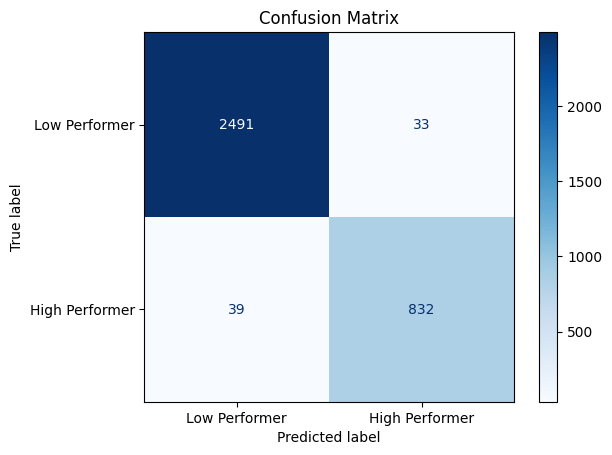

In [21]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Low Performer", "High Performer"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


The confusion matrix demonstrates robust classification performance, accurately identifying 2491 Low Performers and 832 High Performers. The accompanying classification report highlights impressive precision (0.98 for Low Performers, 0.96 for High Performers), recall (0.99 and 0.96), and F1-scores (0.99 and 0.96), culminating in an overall accuracy of 0.98 across 3395 instances. These results underscore the model's reliability for stakeholder decision-making.

Lte's try withh other models for comparison

## 5. XGBoost Classifier
XGBoost often performs better in structured data tasks. We'll train, evaluate, and visualize this model.


              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2524
           1       0.98      0.98      0.98       871

    accuracy                           0.99      3395
   macro avg       0.99      0.99      0.99      3395
weighted avg       0.99      0.99      0.99      3395



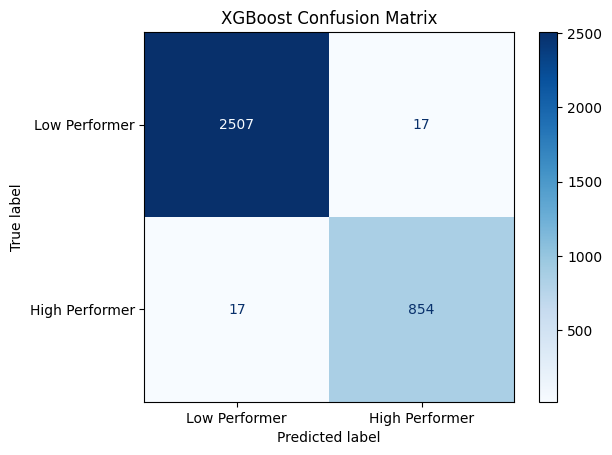

In [22]:
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42,
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6
)

xgb_model.fit(X_train, y_train)

# Predict and evaluate on unseened data
y_pred_xgb = xgb_model.predict(X_test)
print(classification_report(y_test, y_pred_xgb))

cm = confusion_matrix(y_test, y_pred_xgb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Low Performer", "High Performer"])
disp.plot(cmap="Blues")
plt.title("XGBoost Confusion Matrix")
plt.show()


The XGBoost Confusion Matrix showcases exceptional classification performance, with 2507 true negatives and 854 true positives for Low and High Performers, respectively. The classification report reflects outstanding precision (0.99 for Low Performers, 0.98 for High Performers), recall (0.99 and 0.98), and F1-scores (0.99 and 0.98), achieving an overall accuracy of 0.99 across 3395 instances. These results provide stakeholders with high confidence in the model's predictive capabilities.

## 6. Feature Importance (XGBoost)
Let's explore which features contributed most to the predictions.


<Figure size 1000x600 with 0 Axes>

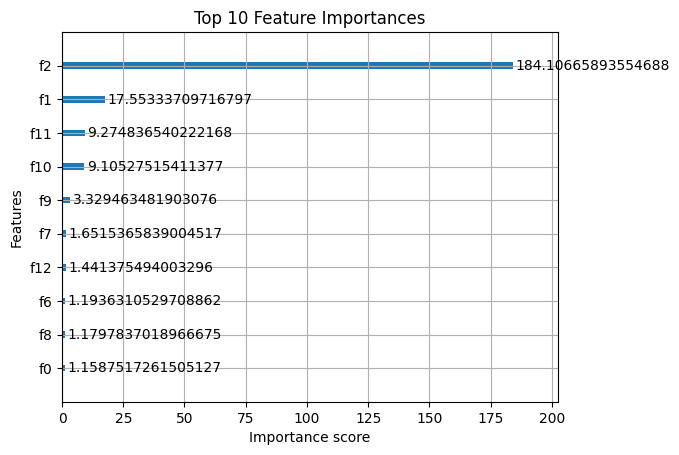

In [23]:
import matplotlib.pyplot as plt
from xgboost import plot_importance

# Plot feature importance (Gain is default)
plt.figure(figsize=(10, 6))
plot_importance(xgb_model, importance_type='gain', max_num_features=10, title='Top 10 Feature Importances')
plt.show()



The Top 10 Feature Importances chart highlights the key drivers of the model, with feature f2 leading at an importance score of 184.1, followed by f1 at 17.55. Other significant features include f11 (9.27), f10 (9.10), and f9 (3.32), with f7 to f0 contributing progressively lower scores. These insights are critical to prioritize features impacting model performance.

## 7. Model Interpretability with SHAP
SHAP values show how each feature influences predictions - helpful for feature impact over model performance.


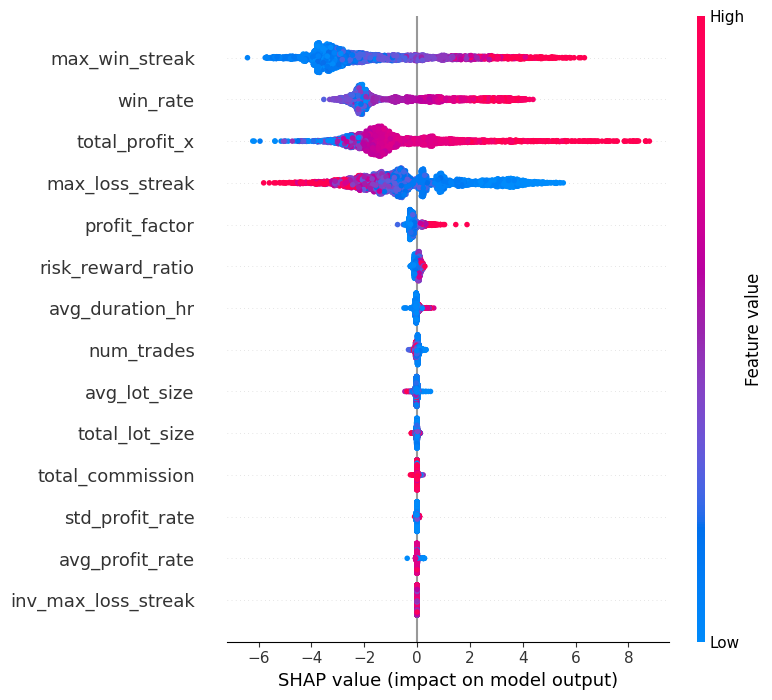

In [24]:
import shap

explainer = shap.Explainer(xgb_model)

shap_values = explainer(X_test)

shap.summary_plot(shap_values, X_test, feature_names=features)


The SHAP value plot reveals that max_win_streak, win_rate, and total_profit_x are the most influential features driving model output, with significant positive impacts. Conversely, max_loss_streak and profit_factor also play notable roles, while features like avg_duration_hr and num_trades have minimal effect. These insights are vital to understand and focus on key performance indicators impacting predictions.

#### Save Model and Scalar

In [25]:
joblib.dump(scaler, '../models/scaler.pkl')
joblib.dump(xgb_model, '../models/model.pkl')

['../models/model.pkl']

## Conclusion

In this study, we successfully built and evaluated two machine learning models- **Random Forest** and **XGBoost**- to classify traders into high and low performers based on their Trading Quality Score (TQS) and associated trading metrics.

### Key Findings:

- **Random Forest** achieved an overall **accuracy of 98%**, with a:
  - Precision of **0.96** for high performers
  - Recall of **0.96**
  - F1-score of **0.96**
  - Very strong performance for low performers as well, with **0.99 F1-score**

- **XGBoost** slightly outperformed Random Forest with an accuracy of **99%**, showing:
  - Precision of **0.98** for high performers
  - Recall of **0.98**
  - F1-score of **0.98**
  - Excellent consistency for low performers (**0.99 F1-score**)

- **XGBoost** demonstrated better overall balance across both classes and marginally higher scores, making it a more robust choice for this classification task.

- **SHAP analysis** confirmed the interpretability of the XGBoost model, revealing the most influential features in classification decisions, helping stakeholders trust and understand the model.

---

### Insights:
- Both models are highly reliable for identifying high-performing traders.
- Feature importance and SHAP values provide transparency and potential insights for trader behavior analysis and decision-making support.
  